# Featurization

This notebook is intended to featurize the data associated with human CRISPRi activity scores to make it easier to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo, Manya Kapoor

---

# Notebook Setup

In [456]:
# dataframes
import pandas as pd

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# regression & support vector machine
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [457]:
# random seed
np.random.seed(0)

# plotting
%matplotlib inline

---

# Data Imports and Checks

In [458]:
# read csvs into dfs & inspect
activity_score_df = pd.read_csv('CRISPRi_Activity_Score_Data.csv')
tss_annotation_df = pd.read_csv('TSS_Annotations.csv')

### Activity Score Dataframe Checks

In [459]:
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]"
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [460]:
# activity_score_df.info

In [461]:
# activity_score_df.dtypes

### TSS Annotation Dataframe Checks

In [462]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


In [463]:
# tss_annotation_df.info

In [464]:
# tss_annotation_df.dtypes

### Column Renaming (for convenience)

In [465]:
new_colnames = {
    "gene symbol" : "gene",
    "PAM genomic coordinate [hg19]" : "coordinate",
    "strand targeted" : "strand",
    "sgRNA length (including PAM)" : "length",
    "sgRNA sequence" : "sequence",
    "CRISPRi activity score [Horlbeck et al., eLife 2016]" : "score"
}
activity_score_df = activity_score_df.rename(columns=new_colnames)

In [466]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [467]:
new_colnames = {
    "TSS source" : "source",
    "Primary TSS, 5'" : "prim 5'",
    "Primary TSS, 3'" : "prim 3'",
    "Secondary TSS, 5'" : "snd 5'",
    "Secondary TSS, 3'" : "snd 3'"
}
tss_annotation_df = tss_annotation_df.rename(columns=new_colnames)

In [468]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,source,prim 5',prim 3',snd 5',snd 3'
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


### Transform Data (for convenience)

In [469]:
# capitalize all sequences
activity_score_df['sequence'] = activity_score_df['sequence'].str.upper()

# map strands {-, +} --> {0, 1}
activity_score_df['+ve strand'] = (activity_score_df['strand'] == '+').astype('int')

In [470]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1


### Cross-Check the Dataframes

During our analysis, we realized the following:

Genes in `tss_annotation_df` may _not_ be unique. Rather, the product of a gene and a transcript is unique. However, there is no transcript information contained within `activity_score_df`. For this reason, if a gene appears in `activity_score_df` that does not correspond to a unique gene in `tss_annotation_df`, it becomes ambiguous which one to use. Given that these constitute a relatively small set, we have chosen to remove these from `activity_score_df`.

A gene in `activity_score_df` may not have an annotation in `tss_annotation_df`. Once again, these constitute a small set, so we remove them.
The following cells implement these fixes.

_NB: A future iteration of this notebook might find ways to better address these ambiguities._

In [471]:
# genes are duplicated in tss_annotation_df
annot_genes_dup_vec = tss_annotation_df['gene'].duplicated()
print(str(sum(annot_genes_dup_vec)) + " genes are duplicated in tss_annotation_df")

1694 genes are duplicated in tss_annotation_df


In [472]:
# the set of duplicated genes
annot_genes_dup = tss_annotation_df['gene'][annot_genes_dup_vec].unique()
print("The following are some of the genes duplicated in tss_annotation_df: " + str(annot_genes_dup[0:5]))

The following are some of the genes duplicated in tss_annotation_df: ['A1BG' 'AARSD1' 'ABAT' 'ABCA7' 'ABCB9']


In [473]:
# genes in activity_score_df that occur in this set are ambiguous
ambiguous_gene_vec = np.isin(activity_score_df['gene'], annot_genes_dup)
print(str(sum(ambiguous_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(ambiguous_gene_vec) * 100)) + 
      "%) of genes in activity_score_df have ambigiuous annotations.")

1113 (or about 6%) of genes in activity_score_df have ambigiuous annotations.


In [474]:
# print ambiguous genes
ambiguous_genes = activity_score_df['gene'][ambiguous_gene_vec].unique()
print("Ambiguous genes are: " + str(ambiguous_genes))

Ambiguous genes are: ['ATP5A1' 'ATP5J2-PTCD1' 'BCL2L1' 'BOD1L1' 'C11orf45' 'CANX' 'CBFA2T3'
 'CCNK' 'CDK6' 'CENPA' 'CKAP5' 'COPS7B' 'COPZ1' 'DDX46' 'DDX54' 'DHODH'
 'DNASE1L1' 'DPH1' 'DYNLRB1' 'EEF2' 'EIF4G2' 'ESF1' 'FBXO8' 'FDFT1' 'FIS1'
 'FOLR3' 'GON4L' 'HAUS7' 'HMG20B' 'IDH3A' 'IFT74' 'IK' 'IL11RA' 'KMT2B'
 'LDB1' 'LSM5' 'MAPKAP1' 'MRPL30' 'MTHFD2' 'NDUFC1' 'NDUFS5' 'NDUFV1'
 'OAZ3' 'PKM' 'PMPCB' 'PNISR' 'POLR1D' 'POLR2D' 'PPP2R1A' 'PRMT5' 'PSMB6'
 'PSPH' 'PTCD1' 'RAB5C' 'RBM4' 'RPS29' 'RSL1D1' 'SEC61A1' 'SF3A1'
 'SLC12A9' 'SLC1A5' 'SNW1' 'ST3GAL2' 'STAG2' 'TACC3' 'TAL1' 'TKT' 'TUBB'
 'UBA1' 'USP39' 'WBP11' 'ZMAT2' 'ZMYM3' 'ZNF574' 'ZNF699']


In [475]:
# remove these ambiguous genes
old_length = len(activity_score_df)
activity_score_df = activity_score_df[np.logical_not(ambiguous_gene_vec)]
new_length = len(activity_score_df)
activity_score_df = activity_score_df.reset_index()

assert (old_length - sum(ambiguous_gene_vec) == new_length)
assert (sum(np.isin(activity_score_df['gene'], annot_genes_dup)) == 0)

print("The ambigious genes have been removed.")

The ambigious genes have been removed.


In [476]:
# set of genes in tss_annotation_df
annot_genes = tss_annotation_df['gene'].unique()
print("The following are some of the genes in tss_annotation_df: " + str(annot_genes[0:5]))

The following are some of the genes in tss_annotation_df: ['A1BG' 'A1CF' 'A2M' 'A2ML1' 'A3GALT2']


In [477]:
# genes in activity_score_df that do not appear in this set are unkown
unknown_gene_vec = np.logical_not(np.isin(activity_score_df['gene'], annot_genes))
print(str(sum(unknown_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(unknown_gene_vec) * 100)) + 
      "%) of genes in activity_score_df have unknown annotations.")

17 (or about 0%) of genes in activity_score_df have unknown annotations.


In [478]:
# print unknown genes
unknown_genes = activity_score_df['gene'][unknown_gene_vec].unique()
print("Ambiguous genes are: " + str(unknown_genes))

Ambiguous genes are: ['NIFK']


In [479]:
# remove these unknown genes
old_length = len(activity_score_df)
activity_score_df = activity_score_df[np.logical_not(unknown_gene_vec)]
new_length = len(activity_score_df)
activity_score_df = activity_score_df.reset_index()

assert (old_length - sum(unknown_gene_vec) == new_length)
assert (sum(np.isin(activity_score_df['gene'], annot_genes)) == new_length)

print("The unknown genes have been removed.")

The unknown genes have been removed.


In [480]:
activity_score_df = activity_score_df[activity_score_df.columns[2:]]

---

# Feature: Distances to TSS Sites

In [481]:
primary_five = []
primary_three = []
secondary_five = []
secondary_three = []

annot_genes = tss_annotation_df['gene']

for index, row in activity_score_df.iterrows():
    
    gene = row['gene']
    PAM_coord = row['coordinate']
    
    primary_five.append(tss_annotation_df["prim 5'"][annot_genes == gene].values[0] - PAM_coord)
    primary_three.append(tss_annotation_df["prim 3'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_five.append(tss_annotation_df["snd 5'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_three.append(tss_annotation_df["snd 3'"][annot_genes == gene].values[0] - PAM_coord)
    
activity_score_df["dist prim 5'"] = primary_five
activity_score_df["dist prim 3'"] = primary_three
activity_score_df["dist snd 5'"] = secondary_five
activity_score_df["dist snd 3'"] = secondary_three

In [482]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,dist prim 5',dist prim 3',dist snd 5',dist snd 3'
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,-58,-20,-19,22
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,167,205,206,247
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,87,125,126,167
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,65,103,104,145
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,21,59,60,101


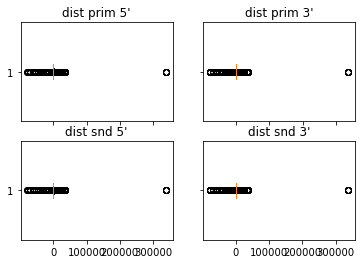

In [483]:
# look at distances
fig, axs = plt.subplots(2, 2)

axs[0, 0].boxplot(activity_score_df["dist prim 5'"], vert=False)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].boxplot(activity_score_df["dist prim 3'"], vert=False)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].boxplot(activity_score_df["dist snd 5'"], vert=False)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].boxplot(activity_score_df["dist snd 3'"], vert=False)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

These boxplots suggest that there are several outliers among the distances. This may be because of incorrect annotations. We will remove extreme outliers, defined as points that are 3 * IQR away from the first or third quartile.

In [484]:
q75_prim5, q25_prim5 = np.percentile(activity_score_df["dist prim 5'"], [75 ,25])
q75_prim3, q25_prim3 = np.percentile(activity_score_df["dist prim 3'"], [75 ,25])
q75_snd5, q25_snd5 = np.percentile(activity_score_df["dist snd 5'"], [75 ,25])
q75_snd3, q25_snd3 = np.percentile(activity_score_df["dist snd 3'"], [75 ,25])

iqr_prim5 = q75_prim5 - q25_prim5
iqr_prim3 = q75_prim3 - q25_prim3
iqr_snd5 = q75_snd5 - q25_snd5
iqr_snd3 = q75_snd3 - q25_snd3

In [485]:
mult = 3

mask_prim5 = np.logical_or(activity_score_df["dist prim 5'"] < q25_prim5 - mult * iqr_prim5, 
                           activity_score_df["dist prim 5'"] > q75_prim5 + mult * iqr_prim5)

mask_prim3 = np.logical_or(activity_score_df["dist prim 3'"] < q25_prim3 - mult * iqr_prim3, 
                           activity_score_df["dist prim 3'"] > q75_prim3 + mult * iqr_prim3)

mask_snd5 = np.logical_or(activity_score_df["dist snd 5'"] < q25_snd5 - mult * iqr_snd5, 
                          activity_score_df["dist snd 5'"] > q75_snd5 + mult * iqr_snd5)

mask_snd3 = np.logical_or(activity_score_df["dist snd 3'"] < q25_snd3 - mult * iqr_snd3, 
                          activity_score_df["dist snd 3'"] > q75_snd3 + mult * iqr_snd3)

mask_sum = (mask_prim5 * 1) + (mask_prim3 * 1) + (mask_snd5 * 1) + (mask_snd3 * 1)

Number of extreme outliers: 884


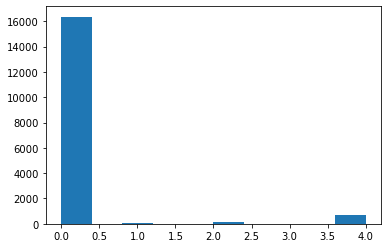

In [486]:
plt.hist(mask_sum)
print("Number of extreme outliers: " + str(sum(mask_sum != 0)))

Ideally, we would see in the above histogram that there are only counts at 0 and 4. This would give us more concrete evidence that the TSS annotations are incorrect (since incorrect TSS annotations would throw off all the distance measurements). However, this is not the case, as the short bars at 1 and 2 indicate. This means that for some measurements (e.g. distance to the upstream primary TSS) are reasonable while others (e.g. distance to downstream secondary TSS) are not. It is harder to justify why this would be the case since an altogether incorrect TSS annotation likely would not cater to some distances while invalidating others. Most likely, these are just borderline datapoints that straddle the definition of an extreme outlier. Nonetheless, we will remove any point which is marked as an extreme outlier for one of the four distance to TSS measurements.

In [487]:
activity_score_df = activity_score_df.loc[mask_sum == 0].reset_index().drop(columns=['index'])

In [488]:
activity_score_df

,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,dist prim 5',dist prim 3',dist snd 5',dist snd 3'
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,-58,-20,-19,22
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,167,205,206,247
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,87,125,126,167
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,65,103,104,145
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,21,59,60,101
...,...,...,...,...,...,...,...,...,...,...,...,...
16361,ZWINT,chr10,58121021,+,24,GTAATCTTAGGGATTGTGGGA,1.147518,1,-25,18,-25,18
16362,ZWINT,chr10,58121033,+,23,GTGACTTCAAAGTAATCTTA,0.618442,1,-37,6,-37,6
16363,ZWINT,chr10,58120760,-,24,GTGGATGTGGGGAGCGGCGAA,0.215028,0,236,279,236,279
16364,ZWINT,chr10,58120818,-,24,GACACCTCAGGAACCTAAGAC,1.170726,0,178,221,178,221


---

# Feature: Longest Consecutive Run of Each Base 

In [489]:
def get_longest_consec(seq):
    """
    The function finds the longest consecutive run of each
    nucleotide base within a sequence in O(n).
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        4-tuple: the entries are the longest consecutive
        run of 'A', 'C', 'G', and 'T' in that order.
    """
    
    max_run = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    current_run = 0
    current_base = None

    for char in seq:
        if char == current_base:
            current_run += 1
        else:
            if current_base != None and current_run > max_run[current_base]:
                max_run[current_base] = current_run
            current_base = char
            current_run = 1
            
    return (max_run['A'], max_run['C'], max_run['G'], max_run['T'])

In [490]:
longest_consec_run_colnames = [
    'longest A',
    'longest C', 
    'longest G', 
    'longest T'
]

longest_consec_run_series = activity_score_df['sequence'].apply(get_longest_consec)

longest_consec_run_df = pd.DataFrame(longest_consec_run_series.tolist(), columns = longest_consec_run_colnames)

activity_score_df = pd.concat([activity_score_df, longest_consec_run_df], axis=1, sort=False)
activity_score_df

,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,dist prim 5',dist prim 3',dist snd 5',dist snd 3',longest A,longest C,longest G,longest T
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,-58,-20,-19,22,1,1,2,2
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,167,205,206,247,1,4,2,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,87,125,126,167,1,3,2,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,65,103,104,145,1,3,2,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,21,59,60,101,1,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16361,ZWINT,chr10,58121021,+,24,GTAATCTTAGGGATTGTGGGA,1.147518,1,-25,18,-25,18,2,1,3,2
16362,ZWINT,chr10,58121033,+,23,GTGACTTCAAAGTAATCTTA,0.618442,1,-37,6,-37,6,3,1,1,2
16363,ZWINT,chr10,58120760,-,24,GTGGATGTGGGGAGCGGCGAA,0.215028,0,236,279,236,279,1,1,4,1
16364,ZWINT,chr10,58120818,-,24,GACACCTCAGGAACCTAAGAC,1.170726,0,178,221,178,221,2,2,2,1


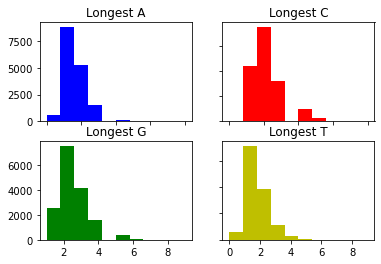

In [491]:
# look at longest consecutive run
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(activity_score_df['longest A'], color="b")
axs[0, 0].set_title('Longest A')
axs[0, 1].hist(activity_score_df['longest C'], color="r")
axs[0, 1].set_title('Longest C')
axs[1, 0].hist(activity_score_df['longest G'], color="g")
axs[1, 0].set_title('Longest G')
axs[1, 1].hist(activity_score_df['longest T'], color="y")
axs[1, 1].set_title('Longest T')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: sgRNA Length

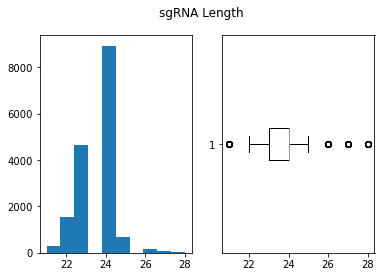

In [492]:
fig, axs = plt.subplots(1, 2)
fig.suptitle("sgRNA Length")


axs[0].hist(activity_score_df['length'])
axs[1].boxplot(activity_score_df['length'], vert=False)

plt.show()

---

# Feature: Nucleotides at Each Position

To maintain the nucleotide at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each position in the longest sequence. Necessarily, some cells will have empty spaces since not all sequences are of equal length.

In [493]:
# get each sequence as a string of the same length, right justified
max_len = max(activity_score_df['sequence'].str.len())
sequence_rjust = activity_score_df['sequence'].apply(lambda x : x.rjust(max_len))

In [494]:
sgRNA_bases = pd.DataFrame(sequence_rjust.apply(list).tolist())
sgRNA_bases['length'] = activity_score_df['sequence'].str.len()
sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,length
0,,,,,G,C,G,C,T,C,...,G,A,C,G,G,A,G,C,G,21
1,,,,,G,C,C,C,C,A,...,G,G,C,C,C,C,G,C,G,21
2,,,,,G,G,C,C,G,C,...,A,G,A,G,C,T,C,T,G,21
3,,,,,G,A,C,G,G,C,...,A,G,G,A,G,A,G,G,T,21
4,,,,,G,G,T,G,C,A,...,C,C,T,T,G,G,C,G,G,21


In [495]:
nucl_prefix = dict()

for i in range(max_len):
    nucl_prefix[i] = "pos_-" + str(max_len - 1 - i + 3) # add'l 3 b/c PAM

In [496]:
a = pd.DataFrame([25 * ['A'] + [0]], columns=sgRNA_bases.columns.tolist())
c = pd.DataFrame([25 * ['C'] + [0]], columns=sgRNA_bases.columns.tolist())
g = pd.DataFrame([25 * ['G'] + [0]], columns=sgRNA_bases.columns.tolist())
t = pd.DataFrame([25 * ['T'] + [0]], columns=sgRNA_bases.columns.tolist())
nucl_tmp = sgRNA_bases.append(a).append(c).append(g).append(t).replace(' ', np.nan)

In [497]:
nucl_onehot = pd.get_dummies(nucl_tmp, prefix=nucl_prefix, dummy_na = False)
nucl_onehot = nucl_onehot[nucl_onehot['length'] != 0]
nucl_onehot.head()

,length,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,pos_-25_A,...,pos_-5_G,pos_-5_T,pos_-4_A,pos_-4_C,pos_-4_G,pos_-4_T,pos_-3_A,pos_-3_C,pos_-3_G,pos_-3_T
0,21,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,21,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,21,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [498]:
# base_encodings = {
#     'A' : 0, 
#     'C' : 1, 
#     'G' : 2, 
#     'T' : 3, 
# }

# for base, repl in _base_encodings.items():
#     sgRNA_bases.replace(dimer, repl, inplace = True)
    
# sgRNA_bases.head()

---

# Feature: Nucleotide Composition

In [499]:
As = []
Cs = []
Gs = []
Ts = []

for index, row in sgRNA_bases.iterrows():
    length = row['length']
    As.append(sum(row == 'A') / length)
    Cs.append(sum(row == 'C') / length)
    Gs.append(sum(row == 'G') / length)
    Ts.append(sum(row == 'T') / length)
    
sgRNA_bases['As'] = As
sgRNA_bases['Cs'] = Cs
sgRNA_bases['Gs'] = Gs
sgRNA_bases['Ts'] = Ts

sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,length,As,Cs,Gs,Ts
0,,,,,G,C,G,C,T,C,...,G,A,G,C,G,21,0.142857,0.238095,0.428571,0.190476
1,,,,,G,C,C,C,C,A,...,C,C,G,C,G,21,0.142857,0.476190,0.333333,0.047619
2,,,,,G,G,C,C,G,C,...,C,T,C,T,G,21,0.095238,0.380952,0.380952,0.142857
3,,,,,G,A,C,G,G,C,...,G,A,G,G,T,21,0.238095,0.238095,0.428571,0.095238
4,,,,,G,G,T,G,C,A,...,G,G,C,G,G,21,0.047619,0.285714,0.523810,0.142857


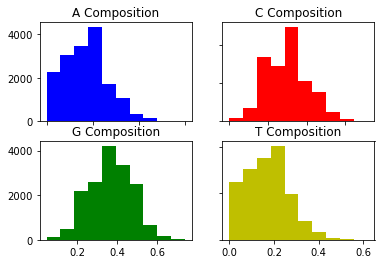

In [500]:
# look at nucleotide composition
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(sgRNA_bases['As'], color="b")
axs[0, 0].set_title('A Composition')
axs[0, 1].hist(sgRNA_bases['Cs'], color="r")
axs[0, 1].set_title('C Composition')
axs[1, 0].hist(sgRNA_bases['Gs'], color="g")
axs[1, 0].set_title('G Composition')
axs[1, 1].hist(sgRNA_bases['Ts'], color="y")
axs[1, 1].set_title('T Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: Dimers at Each Position

Similarly, to maintain the dimer at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each dimer position in the longest sequence. Necessarily, some columns will have `None` since not all sequences are of equal length.

In [501]:
def get_seq_dimers(seq):
    """
    This function returns the dimers of an input sequence
    as a list of two-character strings.
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        list: the entry at position i is the ith dimer,
        captured as a two-character string.
    """
    return [seq[i:i+2] for i in range(0, len(seq)-1)]

In [502]:
# NOTE BUG: Gettting some single nucleotides at the ends
# If odd number of positions, ignore last guy
max_dimer_len = max_len - 1
sequence_rjust = activity_score_df['sequence'].apply(lambda x : x.rjust(max_len))
sgRNA_dimers = pd.DataFrame(sequence_rjust.apply(get_seq_dimers).tolist())

# subtract one b/c one fewer dimers than bases
sgRNA_dimers['length'] = activity_score_df['sequence'].str.len() - 1

sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,,,,G,GC,CG,GC,CT,TC,CT,...,GG,GA,AC,CG,GG,GA,AG,GC,CG,20
1,,,,G,GC,CC,CC,CC,CA,AG,...,AG,GG,GC,CC,CC,CC,CG,GC,CG,20
2,,,,G,GG,GC,CC,CG,GC,CC,...,GA,AG,GA,AG,GC,CT,TC,CT,TG,20
3,,,,G,GA,AC,CG,GG,GC,CG,...,TA,AG,GG,GA,AG,GA,AG,GG,GT,20
4,,,,G,GG,GT,TG,GC,CA,AG,...,CC,CC,CT,TT,TG,GG,GC,CG,GG,20


In [503]:
prefix = dict()
for i in range(max_dimer_len):
    prefix[i] = "pos_-" + str(max_dimer_len - 1 - i + 4)  # add'l 4 b/c PAM

In [504]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dummy_dimers = []
tmp = pd.DataFrame()
tmp = tmp.append(sgRNA_dimers)

for dimer in dimer_encodings.keys():
    dummy_dimers.append(pd.DataFrame([max_dimer_len * [dimer] + [0]], columns=sgRNA_dimers.columns.tolist()))
for df in dummy_dimers:
    tmp = tmp.append(df)

incomplete_dimers = ['  ', ' A', ' C', ' G', ' T']
    
tmp = tmp.replace(incomplete_dimers, np.nan)
tmp.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,NaN,NaN,NaN,NaN,GC,CG,GC,CT,TC,CT,...,GG,GA,AC,CG,GG,GA,AG,GC,CG,20
1,NaN,NaN,NaN,NaN,GC,CC,CC,CC,CA,AG,...,AG,GG,GC,CC,CC,CC,CG,GC,CG,20
2,NaN,NaN,NaN,NaN,GG,GC,CC,CG,GC,CC,...,GA,AG,GA,AG,GC,CT,TC,CT,TG,20
3,NaN,NaN,NaN,NaN,GA,AC,CG,GG,GC,CG,...,TA,AG,GG,GA,AG,GA,AG,GG,GT,20
4,NaN,NaN,NaN,NaN,GG,GT,TG,GC,CA,AG,...,CC,CC,CT,TT,TG,GG,GC,CG,GG,20


In [505]:
dimer_onehot = pd.get_dummies(tmp, prefix=prefix, dummy_na = False)
dimer_onehot.head()

,length,pos_-27_AA,pos_-27_AC,pos_-27_AG,pos_-27_AT,pos_-27_CA,pos_-27_CC,pos_-27_CG,pos_-27_CT,pos_-27_GA,...,pos_-4_CG,pos_-4_CT,pos_-4_GA,pos_-4_GC,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT
0,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [506]:
dimer_onehot = dimer_onehot[dimer_onehot['length'] != 0]
dimer_onehot.head()

,length,pos_-27_AA,pos_-27_AC,pos_-27_AG,pos_-27_AT,pos_-27_CA,pos_-27_CC,pos_-27_CG,pos_-27_CT,pos_-27_GA,...,pos_-4_CG,pos_-4_CT,pos_-4_GA,pos_-4_GC,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT
0,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [507]:
# dimer_encodings = {
#     'AA' : 0, 
#     'AC' : 1, 
#     'AG' : 2, 
#     'AT' : 3, 
#     'CA' : 4, 
#     'CC' : 5, 
#     'CG' : 6, 
#     'CT' : 7,          
#     'GA' : 8, 
#     'GC' : 9, 
#     'GG' : 10, 
#     'GT' : 11, 
#     'TA' : 12, 
#     'TC' : 13, 
#     'TG' : 14, 
#     'TT' : 15
# }

# for dimer, repl in encodings.items():
#     sgRNA_dimers.replace(dimer, repl, inplace = True)
    
# sgRNA_dimers.head()

---

# Feature: Dimer Composition

In [508]:
# Relevant dimers that the paper decsribes: GC, CA, AG
GC = []
CA = []
AG = []

for index, row in sgRNA_dimers.iterrows():
    length = row['length']
    GC.append(sum(row == 'GC') / length)
    CA.append(sum(row == 'CA') / length)
    AG.append(sum(row == 'AG') / length)

sgRNA_dimers['GC'] = GC
sgRNA_dimers['CA'] = CA
sgRNA_dimers['AG'] = AG
              
sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,length,GC,CA,AG
0,,,,G,GC,CG,GC,CT,TC,CT,...,CG,GG,GA,AG,GC,CG,20,0.15,0.00,0.05
1,,,,G,GC,CC,CC,CC,CA,AG,...,CC,CC,CC,CG,GC,CG,20,0.15,0.10,0.10
2,,,,G,GG,GC,CC,CG,GC,CC,...,AG,GC,CT,TC,CT,TG,20,0.15,0.00,0.10
3,,,,G,GA,AC,CG,GG,GC,CG,...,GA,AG,GA,AG,GG,GT,20,0.05,0.00,0.15
4,,,,G,GG,GT,TG,GC,CA,AG,...,TT,TG,GG,GC,CG,GG,20,0.20,0.05,0.05


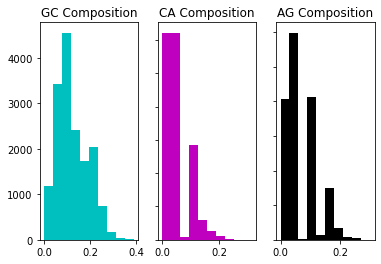

In [509]:
# look at nucleotide composition
fig, axs = plt.subplots(1, 3)

axs[0].hist(sgRNA_dimers['GC'], color="c")
axs[0].set_title('GC Composition')
axs[1].hist(sgRNA_dimers['CA'], color="m")
axs[1].set_title('CA Composition')
axs[2].hist(sgRNA_dimers['AG'], color="k")
axs[2].set_title('AG Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Relationship between CRISPRi activity and sgRNA position relative to the TSS as predicted by SVR.

In [420]:
# SVR trained on an 80% division of the CRISPRi activity score dataset
# using the position of the sgRNA relative to the upstream end of TSS for each gene.

X3p = np.array(activity_score_df["dist prim 3'"]).reshape(-1, 1)
X5p = np.array(activity_score_df["dist prim 5'"]).reshape(-1, 1)
X3s = np.array(activity_score_df["dist snd 3'"]).reshape(-1, 1)
X5s = np.array(activity_score_df["dist snd 5'"]).reshape(-1, 1)
y = np.array(activity_score_df['score'])

As in the paper, we perform a cross-validation grid search to find the appropriate hyperparameters for our SVR model. Our modest computing power limits the scope of our search. Even using this grid search, we attain unimpressive scores. The lack of the author's mention of their parameters or scores makes it difficult to verify whether we are indeed doing this correctly. We will have to look further down the pipeline and iterate at this bottleneck.

In [421]:
parameters = { 'C':[0.6, 0.65, 0.7, 0.75, 0.8, 0.85] }

svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X3p, y)

# many iterations were performed, found that this range was the best

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]})

In [423]:
regr3p = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf', C=clf.best_params_['C']))
regr3p.fit(X3p, y) 
regr3p.score(X3p, y)

0.012535945930976067

In [424]:
parameters = { 'C':[0.6, 0.65, 0.7, 0.75, 0.8, 0.85] }

svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X5p, y)

# many iterations were performed, found that this range was the best

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]})

In [425]:
regr5p = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf', C=clf.best_params_['C']))
regr5p.fit(X5p, y) 
regr5p.score(X5p, y)

0.012168528137641466

In [426]:
parameters = { 'C':[0.8, 0.85, 0.9, 0.95] }

svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X3s, y)

# many iterations were performed, found that this range was the best

GridSearchCV(estimator=SVR(), param_grid={'C': [0.8, 0.85, 0.9, 0.95]})

In [427]:
regr3s = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf', C=clf.best_params_['C']))
regr3s.fit(X3s, y) 
regr3s.score(X3s, y)

-0.03169251777165494

In [428]:
parameters = { 'C':[0.8, 0.85, 0.9, 0.95] }

svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X5s, y)

# many iterations were performed, found that this range was the best

GridSearchCV(estimator=SVR(), param_grid={'C': [0.8, 0.85, 0.9, 0.95]})

In [429]:
regr5s = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf', C=clf.best_params_['C']))
regr5s.fit(X5s, y) 
regr5s.score(X5s, y)

-0.031534407318972946

In [430]:
# To display the relationship between sgRNA position and CRISPRi activity fit by this model, 
# predicted scores were generated for each position within a 3 kb window around the TSS. 
# Graph produced --> lets make it too!!! TODO

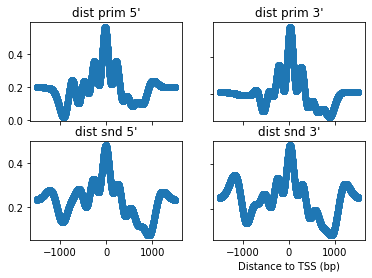

In [431]:
x_pseudo = np.arange(-1500, 1500)
y_pred3s = regr3s.predict(x_pseudo.reshape(-1, 1))
y_pred5s = regr5s.predict(x_pseudo.reshape(-1, 1))
y_pred3p = regr3p.predict(x_pseudo.reshape(-1, 1))
y_pred5p = regr5p.predict(x_pseudo.reshape(-1, 1))

fig, axs = plt.subplots(2, 2)
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('SVR Fit Activity (arbitrary units)')

axs[0, 0].scatter(x_pseudo, y_pred5p)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].scatter(x_pseudo, y_pred3p)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].scatter(x_pseudo, y_pred5s)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].scatter(x_pseudo, y_pred3s)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

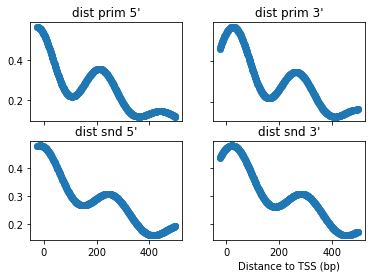

In [432]:
x_pseudo = np.arange(-25, 500)
y_pred3s = regr3s.predict(x_pseudo.reshape(-1, 1))
y_pred5s = regr5s.predict(x_pseudo.reshape(-1, 1))
y_pred3p = regr3p.predict(x_pseudo.reshape(-1, 1))
y_pred5p = regr5p.predict(x_pseudo.reshape(-1, 1))

fig, axs = plt.subplots(2, 2)
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('SVR Fit Activity (arbitrary units)')

axs[0, 0].scatter(x_pseudo, y_pred5p)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].scatter(x_pseudo, y_pred3p)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].scatter(x_pseudo, y_pred5s)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].scatter(x_pseudo, y_pred3s)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

In [433]:
y_pred3s = regr3s.predict(np.array(activity_score_df["dist snd 3'"]).reshape(-1, 1))
y_pred5s = regr5s.predict(np.array(activity_score_df["dist snd 5'"]).reshape(-1, 1))
y_pred3p = regr3p.predict(np.array(activity_score_df["dist prim 3'"]).reshape(-1, 1))
y_pred5p = regr5p.predict(np.array(activity_score_df["dist prim 5'"]).reshape(-1, 1))

In [434]:
d = {
    "dist prim 3'" : y_pred3p,
    "dist prim 5'" : y_pred5p,
    "dist snd 3'" : y_pred3s,
    "dist snd 5'" : y_pred5s
}
SVR_df = pd.DataFrame(data = d)
SVR_df

,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.478330,0.518617,0.479795,0.479443
1,0.270749,0.307569,0.295142,0.294326
2,0.267925,0.234560,0.266423,0.275421
3,0.342018,0.288672,0.286673,0.299012
4,0.510186,0.459465,0.366557,0.381031
...,...,...,...,...
16361,0.565139,0.564897,0.479597,0.477399
16362,0.550711,0.560272,0.474722,0.468717
16363,0.338423,0.334505,0.307945,0.307223
16364,0.301748,0.327758,0.276695,0.276395


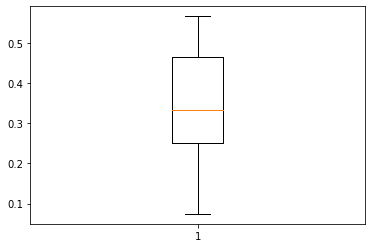

In [435]:
plt.boxplot(SVR_df["dist prim 3'"])
plt.show()

# Make Final Dataframes of all Features

In [510]:
activity_score_df_cols = [
    "score",
    "+ve strand",
    "length",
    "longest A",
    "longest C",
    "longest G",
    "longest T"
]
activity_score_df_features = activity_score_df[activity_score_df_cols]

sgRNA_bases_cols = [
    "As",
    "Cs",
    "Gs",
    "Ts"
]
sgRNA_bases_features = sgRNA_bases[sgRNA_bases_cols]

sgRNA_dimers_cols = [
    "GC",
    "CA",
    "AG"
]
sgRNA_dimers_features = sgRNA_dimers[sgRNA_dimers_cols]

nucl_onehot_features = nucl_onehot.iloc[:, 1:]
dimer_onehot_features = dimer_onehot.iloc[:, 1:]

SVR_df_features = SVR_df

In [511]:
features_df_list = [
    activity_score_df_features, 
    sgRNA_bases_features, 
    sgRNA_dimers_features, 
    nucl_onehot_features, 
    dimer_onehot_features, 
    SVR_df_features
]
features_df = pd.concat(features_df_list, axis = 1)
features_df.head()

,score,+ve strand,length,longest A,longest C,longest G,longest T,As,Cs,Gs,...,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.019320,1,24,1,1,2,2,0.142857,0.238095,0.428571,...,0,0,0,0,0,0,0.478330,0.518617,0.479795,0.479443
1,0.348892,1,24,1,4,2,1,0.142857,0.476190,0.333333,...,0,0,0,0,0,0,0.270749,0.307569,0.295142,0.294326
2,0.912409,1,24,1,3,2,1,0.095238,0.380952,0.380952,...,0,0,0,0,1,0,0.267925,0.234560,0.266423,0.275421
3,0.997242,1,24,1,3,2,1,0.238095,0.238095,0.428571,...,0,1,0,0,0,0,0.342018,0.288672,0.286673,0.299012
4,0.962154,1,24,1,3,3,2,0.047619,0.285714,0.523810,...,1,0,0,0,0,0,0.510186,0.459465,0.366557,0.381031


In [512]:
features_df.to_csv("features.csv")

In [513]:
features_df

,score,+ve strand,length,longest A,longest C,longest G,longest T,As,Cs,Gs,...,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.019320,1,24,1,1,2,2,0.142857,0.238095,0.428571,...,0,0,0,0,0,0,0.478330,0.518617,0.479795,0.479443
1,0.348892,1,24,1,4,2,1,0.142857,0.476190,0.333333,...,0,0,0,0,0,0,0.270749,0.307569,0.295142,0.294326
2,0.912409,1,24,1,3,2,1,0.095238,0.380952,0.380952,...,0,0,0,0,1,0,0.267925,0.234560,0.266423,0.275421
3,0.997242,1,24,1,3,2,1,0.238095,0.238095,0.428571,...,0,1,0,0,0,0,0.342018,0.288672,0.286673,0.299012
4,0.962154,1,24,1,3,3,2,0.047619,0.285714,0.523810,...,1,0,0,0,0,0,0.510186,0.459465,0.366557,0.381031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16361,1.147518,1,24,2,1,3,2,0.238095,0.047619,0.380952,...,0,0,0,0,0,0,0.565139,0.564897,0.479597,0.477399
16362,0.618442,1,23,3,1,1,2,0.350000,0.150000,0.150000,...,0,0,1,0,0,0,0.550711,0.560272,0.474722,0.468717
16363,0.215028,0,24,1,1,4,1,0.190476,0.095238,0.571429,...,0,0,0,0,0,0,0.338423,0.334505,0.307945,0.307223
16364,1.170726,0,24,2,2,2,1,0.380952,0.333333,0.190476,...,0,0,0,0,0,0,0.301748,0.327758,0.276695,0.276395
